In [21]:
import data_challenge_library as dcl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from MuyGPyS.examples.classify import do_classify
from sklearn.preprocessing import LabelBinarizer
from sklearn.utils import shuffle
from MuyGPyS.gp.deformation import F2, Isotropy
from MuyGPyS.gp.hyperparameter import Parameter
from MuyGPyS.gp.kernels import RBF
from MuyGPyS.gp.noise import HomoscedasticNoise
#from MuyGPyS.optimize import Bayes_optimize
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay


In [2]:
object_table = dcl.load_table(have_images = True)
object_table, validation_table = train_test_split(object_table, test_size = 0.1, random_state= 2121805)

table has 446487 sources
class
Gal         246225
Star         96715
Qso          83130
Agn           5608
highZQso      1089
Name: count, dtype: int64
Keeping 432767 labeled sources
Keeping 142963 with all features used in Savic+23
Keeping 142963 with available cutouts


In [3]:
X = object_table.drop(columns=["class", "label"])
y = object_table["label"].to_numpy().astype('int32')
objectID = object_table.index
X, y, objectID = shuffle(X, y, objectID, random_state = 2605)

In [7]:
X_train, X_test, y_train, y_test, objectID_train, objectID_test = train_test_split(X, y, 
                                objectID, test_size = 0.5, random_state = 1406)
scaler = StandardScaler()
scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)
display(X_train.shape, X_test.shape)

(64333, 62)

(64333, 62)

In [8]:
## Trassforming to One hot 
enc = LabelBinarizer()
y_h_test = enc.fit_transform(y_test)
y_h_train = enc.fit_transform(y_train)

In [13]:
nn_kwargs = {"nn_method": "exact", "algorithm": "ball_tree"}
k_kwargs = { "kernel": RBF( deformation= Isotropy(metric=F2,length_scale=Parameter(0.5, (0.01, 1)))),
             "noise": HomoscedasticNoise(1e-5)}

In [14]:
muygps, nbrs_lookup, surrogate_predictions = do_classify(test_features=X_test, train_features=X_train, 
                                                             train_labels=y_h_train,  nn_count=30, verbose=False,
                                                             nn_kwargs=nn_kwargs, k_kwargs=k_kwargs) 

Data point [1.] is not unique. 1 duplicates registered. Continuing ...
Data point [1.] is not unique. 2 duplicates registered. Continuing ...
Data point [1.] is not unique. 3 duplicates registered. Continuing ...
Data point [1.] is not unique. 4 duplicates registered. Continuing ...
Data point [1.] is not unique. 5 duplicates registered. Continuing ...
Data point [1.] is not unique. 6 duplicates registered. Continuing ...
Data point [1.] is not unique. 7 duplicates registered. Continuing ...
Data point [1.] is not unique. 8 duplicates registered. Continuing ...
Data point [1.] is not unique. 9 duplicates registered. Continuing ...
Data point [1.] is not unique. 10 duplicates registered. Continuing ...
Data point [1.] is not unique. 11 duplicates registered. Continuing ...
Data point [1.] is not unique. 12 duplicates registered. Continuing ...
Data point [1.] is not unique. 13 duplicates registered. Continuing ...
Data point [1.] is not unique. 14 duplicates registered. Continuing ...
D

In [17]:
predictions = np.argmax(surrogate_predictions, axis = 1)

[0.98939596 0.97352512 0.94894532]
MuyGPy provided 0.9741190368862015 overall as accuracy


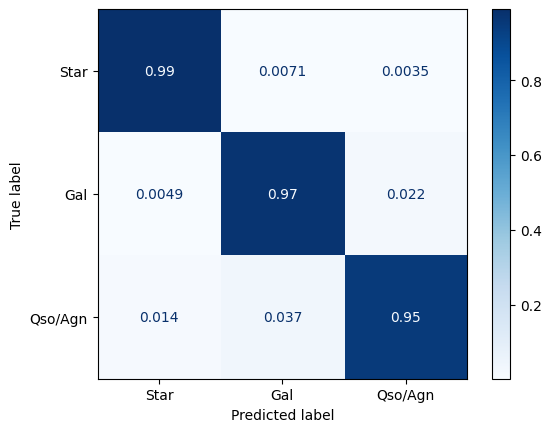

In [22]:
cf = confusion_matrix(y_test, predictions, normalize = "true")
str_labels = ['Star', 'Gal', 'Qso/Agn']
accuracy = cf.diagonal()/cf.sum(axis=1)
print(accuracy)
print(f"MuyGPy provided {accuracy_score(y_test, predictions)} overall as accuracy")
ConfusionMatrixDisplay(cf, display_labels=str_labels).plot(cmap=mpl.cm.Blues);

## Use Images

In [37]:
from torch import nn
import torch
from torch.nn.functional import one_hot
from torch.optim.lr_scheduler import ExponentialLR
from MuyGPyS.neighbors import NN_Wrapper

In [26]:
train_images = dcl.load_images(objectID_train, as_tensor = True)
test_images = dcl.load_images(objectID_test, as_tensor=True)

In [33]:
y_h_test = one_hot(torch.tensor(y_test, dtype = torch.int64))
y_h_train = one_hot(torch.tensor(y_train, dtype = torch.int64))

In [38]:
nn_count = 30
nbrs_lookup = NN_Wrapper(train_images, nn_count, nn_method="exact")


ValueError: too many values to unpack (expected 2)

In [35]:
from MuyGPyS.neighbors import NN_Wrapper

In [36]:
?NN_Wrapper

Init signature:
NN_Wrapper(
    train: numpy.ndarray,
    nn_count: int,
    nn_method: str = 'exact',
    **kwargs,
)
Docstring:     
Nearest Neighbors lookup datastructure wrapper.

Wraps the logic driving nearest neighbor data structure training and
querying. Currently supports `sklearn.neighbors.NearestNeighbors` for exact
computation and `hnswlib.Index` for approximate nearest neighbors.

An example constructing exact and approximate KNN data lookups with k = 10.

Example:
    >>> from MuyGPyS.neighors import NN_Wrapper
    >>> train_features = load_train_features()
    >>> nn_count = 10
    >>> exact_nbrs_lookup = NN_Wrapper(
    ...         train_features, nn_count, nn_method="exact", algorithm="ball_tree"
    ... )
    >>> approx_nbrs_lookup = NN_Wrapper(
    ...         train_features, nn_count, nn_method="hnsw", space="l2", M=16
    ... )


Args:
    train:
        The full training data of shape `(train_count, feature_count)` that
        will construct the nearest neighbor 